In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# TO FIX in nokka parser
# stat display order
# stat combination rules (also fix the elemental min/max damage combination)
# max HP
# "Atlus" suffix

In [2]:
def cb_factor(boss, ranged, pr):
    alpha = 1./8 if boss else 1./4
    if ranged: alpha /= 2.
    alpha *= min(max(1-pr, 0), 1) # crushing blow dmg decreased by PR but cannot be increased with -PR
    #alpha *= 2./(nplayers+1) # crushing blow penalized with many players
    return alpha

# Apply crushing blow and return the remaining life
# life: the starting life value
# N: the number of players
# boss: True if boss
# ranged: True if ranged attack
# pr: physical resist
# chance: chance of CB
def apply_cb(life, N, boss=False, ranged=False, pr=0, chance=1):
    cbgood = np.random.binomial(1,chance)
    if cbgood:
        return (1-cb_factor(boss, ranged, pr)*2./(N+1))*life
    else:
        return life

# Apply crushing blow and the damage, return the remaining life
def apply_hit(life, damage, N, boss=False, ranged=False, pr=0, cb_chance=1):
    return apply_cb(life, N, boss, ranged, pr, chance=cb_chance) - damage*max(1-pr,0)

# Return number of hits to kill a monster
def hits_to_kill(life_p1, damage, N, boss=False, ranged=False, pr=0, cb_chance=1):
    damage *= max(1-pr,0)
    if cb_chance == 0:
        return 1.0*life_p1*0.5*(N+1)/damage
    beta = 1-cb_factor(boss, ranged, pr)*2./(N+1)*cb_chance
    #return -np.log((1-beta)*life/damage + 1)/np.log(beta)
    return -np.log(cb_factor(boss,ranged,pr)*cb_chance*life_p1/damage +1)/np.log(beta)

# 1 - beta = cb_factor(boss, ranged, pr)*2./(N+1)*cb_chance
# (1-beta)*p1_life*0.5*(N+1) = cb_factor(boss, ranged, pr)*cb_chance*p1_life
# return -np.log(cb_factor(boss,ranged,pr)*cb_chance*p1_life/damage +1)/np.log(beta)

# formula from madscientist post
def ms_formula(L, average_damage, nr_players, boss=False, p=0, p_cb=1, p_hit=1):
    e_cb = 1./8 if boss else 1./4
    x = 1-p_hit*p_cb*(1-p)*e_cb*2/(nr_players+1)
    y = p_hit*average_damage*(1-p)
    # n = (np.log(y)-np.log(L*(1-p)+y))/np.log(x)
    # above formula kept in original form, but equivalent to
    # n = -np.log(L*(1-p)/y+1)/np.log(x)
    # substitute for y
    n = -np.log(L/(p_hit*average_damage)+1)/np.log(x)
    # this form makes it more obvious what went wrong when comparing to hits_to_kill formula
    return n

# my formula, but it takes life @ Px instead of life @ P1
def M81_formula(life, damage, N, boss=False, ranged=False, pr=0, cb_chance=1):
    return hits_to_kill(life*2./(N+1), damage, N, boss=boss, ranged=ranged, pr=pr, cb_chance=cb_chance)

<IPython.core.display.Javascript object>


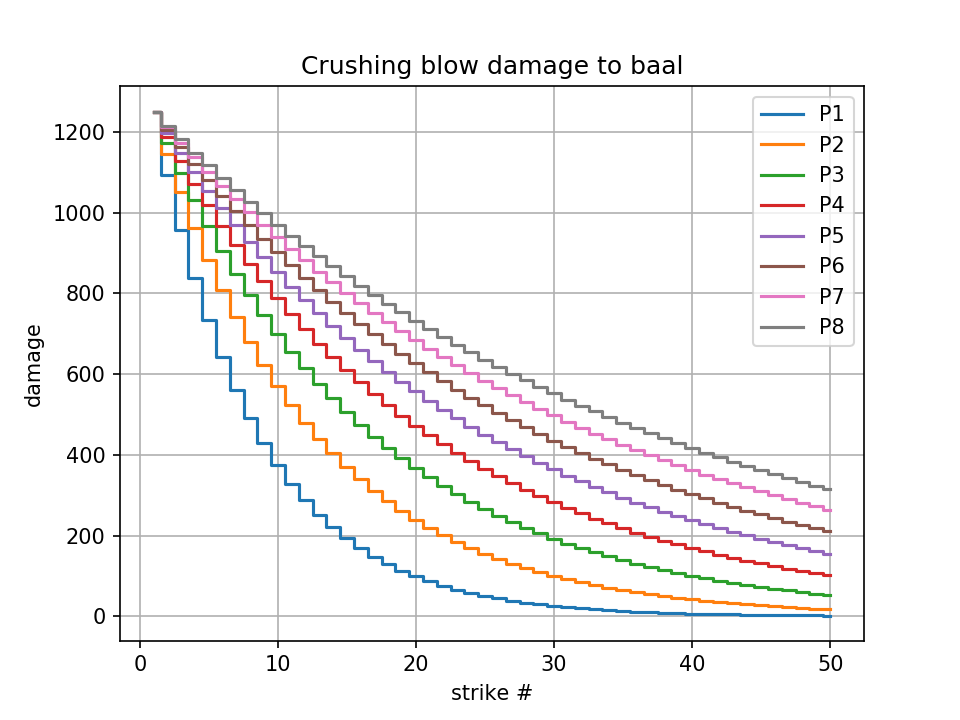

In [10]:
nplayers = [1,2,3,4,5,6,7,8]
nhits = 50
cbs_per_second = 11.8
monster_hp = 10000 #493701
dps_mode = False
if not dps_mode:
    cbs_per_second = 1.0
t = np.array(range(nhits+1))/cbs_per_second
plt.figure()

for n in nplayers:
    life = np.zeros(nhits+1)
    starting_life = monster_hp*0.5*(1+n)
    life[0] = starting_life
    for i in range(nhits):
        life[i+1] = apply_cb(life[i], n, boss=True, ranged=False)


    if not dps_mode:
        plt.step(t[1:], -1.0*np.diff(life)/np.diff(t), where='mid')
        #plt.step(t, life, where='mid')
    else:
        plt.plot(t[1:], -1.0*np.diff(life)/np.diff(t))
if not dps_mode:
    plt.xlabel('strike #')
    plt.ylabel('damage')
else:
    plt.xlabel('t [s]')
    plt.ylabel('dps')
plt.title('Crushing blow damage to baal')
plt.legend(['P'+str(n) for n in nplayers])
#plt.xticks(np.arange(0,101,step=10))
plt.grid(axis='both')

In [22]:
#damage = 29070
damage = 39*(1+3.3)*(1+3+2+2.88)
print('damage: {:.2f}'.format(damage))
print('M81 formula: {:.2f}'.format(M81_formula(monster_hp*0.5*(1+1), damage, 1, boss=False, ranged=True, cb_chance=0.001, pr=0.5)))
print('MadScientist formula: {:.2f}'.format(ms_formula(monster_hp*0.5*(8+1), damage, 8, boss=True, p_cb=0.5, p_hit=1)))
print('No crushing blow (life/damage): {:.2f}'.format(monster_hp*0.5*(1+1)/(damage)))

damage: 1489.18
M81 formula: 13.42
MadScientist formula: 246.03
No crushing blow (life/damage): 6.72


In [4]:
trials = 10000
Nplayers = 8
nhits_list = []
for trial in range(trials):
    mlife = monster_hp*0.5*(1+Nplayers)
    nhits = 0
    while mlife > 0:
        mlife = apply_hit(mlife, damage, Nplayers, boss=True, cb_chance=0.5)
        nhits += 1
    nhits_list.append(nhits)

NameError: name 'damage' is not defined

In [5]:
plt.figure()
plt.hist(nhits_list)
print np.average(nhits_list)

SyntaxError: invalid syntax (<ipython-input-5-6ed9ee8c2722>, line 3)

In [7]:
print 'simulation result: {:.2f}'.format(np.average(nhits_list))
print 'M81 formula: {:.2f}'.format(M81_formula(monster_hp*0.5*(8+1), damage, 8, boss=True, cb_chance=0.5))
print 'MadScientist formula: {:.2f}'.format(ms_formula(monster_hp*0.5*(8+1), damage, 8, boss=True, p_cb=0.5, p_hit=1))
print 'No crushing blow (life/damage): {:.2f}'.format(monster_hp*0.5*(8+1)/(damage))

simulation result: 52.18
M81 formula: 51.72
MadScientist formula: 310.97
No crushing blow (life/damage): 76.42


In [8]:
import abc

class MagicProperties(object):
    def __init__(self, ias=0, ed=0, cb=0, ds=0, maxdmg=0, mindmg=0):
        self.ias = ias
        self.ed = ed
        self.cb = cb
        self.ds = ds
        self.maxdmg = maxdmg
        self.mindmg = mindmg
        
    def __add__(self, mp):
        return MagicProperties(ias=self.ias+mp.ias,
                               ed=self.ed+mp.ed,
                               cb=self.cb+mp.cb,
                               ds=self.ds+mp.ds,
                               maxdmg=self.maxdmg+mp.maxdmg,
                               mindmg=self.mindmg+mp.mindmg)

class Item(object):
    def __init__(self):
        self.mp = MagicProperties()
        
    # create an item with the given magic properties
    @classmethod
    def create(cls, mp, *args, **kwargs):
        item = cls(*args, **kwargs)
        item.mp = mp
        return item
    
class Socketable(Item):
    def __init__(self, *args, **kwargs):
        Item.__init__(self)
        self.mp = MagicProperties(*args, **kwargs)

class Equipable(Item):
    pass

class Weapon(Equipable):
    def __init__(self, eth=False, sockets=0):
        Equipable.__init__(self)
        self.socketables = []
        self.sockets = sockets
        self.eth = eth
        
    def add_socketable(self, socketable):
        if len(self.socketables) < self.sockets:
            self.socketables.append(socketable)

    def avg_damage(self):
        return (self.max_damage()+self.min_damage())/2.0
    
    def max_damage(self):
        return self.compute_dmg(self.maxdmg, self.total_mp().maxdmg)
    
    def min_damage(self):
        return self.compute_dmg(self.mindmg, self.total_mp().mindmg)
    
    def compute_dmg(self, basedmg, adds_dmg):
        dmg = basedmg
        if self.eth: dmg *= 1.5
        dmg *= (1+self.total_mp().ed)
        dmg += adds_dmg
        return dmg
    
    def total_mp(self):
        return reduce(lambda x,y: x+y, [s.mp for s in self.socketables], self.mp)
    
    def total_ed(self):
        return self.total_mp().ed
    
    def total_ias(self):
        return self.total_mp().ias

class Staff(Weapon):
    wtype='STF'
    
class TwoHandSword(Weapon):
    wtype='2HS'
    
class HandToHand(Weapon):
    wtype='HTH'
    
class CrypticAxe(Staff):
    mindmg = 33
    maxdmg = 150
    wsm = 10
        
class Stalagmite(Staff):
    mindmg = 75
    maxdmg = 107
    wsm = 10

class ColossusSword(TwoHandSword):
    mindmg = 61
    maxdmg = 121
    wsm = 10
    
class ColossusBlade(TwoHandSword):
    mindmg = 58
    maxdmg = 115
    wsm = 5
    
class Runeword(MagicProperties):
    pass
    
class Death(Runeword):
    def __init__(self, ed=3.85):
        MagicProperties.__init__(self)
        self.ed = ed
        self.cb = 0.5
        self.ds = 0
        
class BreathOfTheDying(Runeword):
    def __init__(self, ed=4.0):
        MagicProperties.__init__(self)
        self.ed = ed
        self.ias = 60
    
class TombReaver(CrypticAxe):
    def __init__(self, ed=2.8, sockets=3, eth=False):
        CrypticAxe.__init__(self, eth=eth, sockets=sockets)
        self.mp.ed = ed
        self.mp.ias = 60
        
class Ribcracker(Stalagmite):
    def __init__(self, ed=3.0, sockets=1, eth=False):
        Stalagmite.__init__(self, eth=eth, sockets=sockets)
        self.mp.ed = ed
        self.mp.ias = 50
        self.mp.mindmg = 30
        self.mp.maxdmg = 65
        

rjof = Socketable(ed=0.4, ias=15)
vjoc = Socketable(maxdmg=30)
ber = Socketable(cb=20)
    
ca = CrypticAxe(eth=True)
print ca.avg_damage()

etr = TombReaver(eth=True)
etr.add_socketable(rjof)
etr.add_socketable(rjof)

print 'eth tomb reaver'
print etr.avg_damage(), etr.min_damage(), etr.max_damage()
print etr.total_ias()
print etr.total_ed()
print 'ribcracker'
rb = Ribcracker(eth=False)
rb.add_socketable(rjof)
print rb.avg_damage(), rb.min_damage(), rb.max_damage()

print 'death colossus sword'
death_cs = ColossusSword.create(Death(), eth=True)
print death_cs.avg_damage()

ebotd_cb = ColossusBlade.create(BreathOfTheDying(), eth=True)

137.25
eth tomb reaver
631.35 227.7 1035.0
90
3.6
ribcracker
447.9 360.0 535.8
death colossus sword
662.025


In [9]:
off_weapon_ed = 2.0+2+3 # str, might, fort
insight_damage = 91.5*1.5*(1+2.6)*(1+off_weapon_ed)*1.46
obed_damage = 91.5*1.5*(1+3.7)*(1+off_weapon_ed)
obed_fast_damage = 77*1.5*(1+3.7)*(1+2+2.0)
reaper_damage = 77*1.5*(1+2.4)*(1+off_weapon_ed)*1.48
#print insight_damage, obed_damage
NNplayers = 8
mhp = 25000.
#print 1.0*mhp/insight_damage
print hits_to_kill(mhp, insight_damage, NNplayers, boss=True, cb_chance=0.0, pr=0.33)
print hits_to_kill(mhp, obed_damage, NNplayers, boss=True, cb_chance=0.4, pr=0.33)
print hits_to_kill(mhp, obed_fast_damage, NNplayers, boss=True, cb_chance=0.4, pr=0.33)*11./14

29.0951113137
29.027238308811075
39.83106393730772


In [10]:
reaper_damage

4649.568

In [11]:
7.79/8.13

0.9581795817958179

If we compare the damage that a particular setup does with and without CB across number of players, the results are a bit surprising. The ratio of hits required to kill without CB to hits required to kill with CB *decreases* with player count. That means that if it took 10 hits to kill a monster without CB and 9 to kill him with CB at P1, it could take 45 and 43, respectively at P8. The setup with CB will obviously always be better in this case (more damage = better), but the way the scaling works is the surprising part. The scaling does change very little with player count, ~5% at the most across the P1-P8 range.

Another interesting thing is that this ratio approaches a constant as the number of players approaches infinity, meaning that CB is no more or less effective at high player counts.

<IPython.core.display.Javascript object>


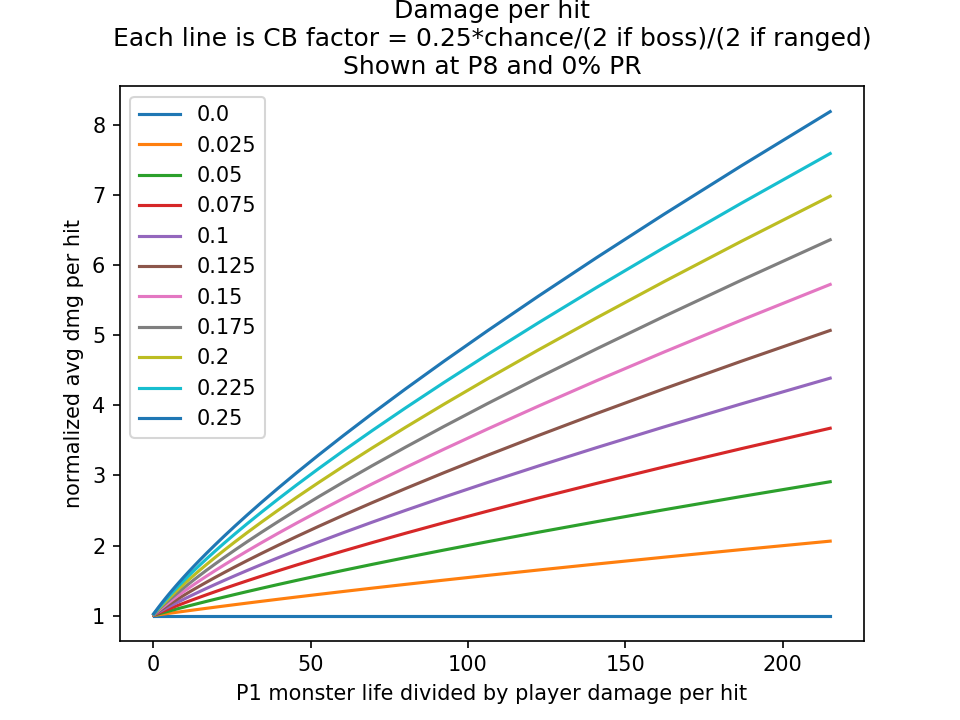

Text(0,0.5,'normalized avg dmg per hit')

In [12]:
# look at hits required to kill hell baal across player count
n = np.array(range(8))+1
mlife = np.logspace(3,6,num=50)
plt.figure()
mlifes = [10e3, 20e3, 50e3, 100e3, 200e3, 500e3]
cb_chances = np.array(range(11))/10.0
#for mlife in mlifes:
#for ni in n:
for cb_chance in cb_chances:
    #plt.plot(n, hits_to_kill(mlife, obed_damage, n, boss=True, cb_chance=0.5, pr=0.0)/hits_to_kill(mlife, obed_damage, n, boss=True, cb_chance=0.0, pr=0.0))
    #plt.plot(mlife/obed_damage, hits_to_kill(mlife, obed_damage, ni, boss=True, cb_chance=0.0, pr=0.0)/hits_to_kill(mlife, obed_damage, ni, boss=True, cb_chance=0.5, pr=0.0))
    plt.plot(mlife/reaper_damage, hits_to_kill(mlife, reaper_damage, 8, boss=False, cb_chance=0, pr=0.0)/hits_to_kill(mlife, reaper_damage, 8, boss=True, cb_chance=cb_chance, pr=0.0))
#plt.legend(['{:.2f}'.format(x/obed_damage) for x in mlifes])
#plt.legend(n)
plt.legend(cb_chances/4)
#plt.title('Ratio of hits to kill without CB to with CB\n50% CB chance, 0% PR, champ/unique/boss')
plt.title('Damage per hit\nEach line is CB factor = 0.25*chance/(2 if boss)/(2 if ranged)\nShown at P8 and 0% PR')
plt.xlabel('P1 monster life divided by player damage per hit')
#plt.xlabel('number of players')
#plt.ylabel('hits to kill without CB / hits to kill with CB')
plt.ylabel('normalized avg dmg per hit')

In [13]:
# lister calcs
# infinity thresher
inf_thresh_fort_dmg = 77*1.5*(1+3.25)*(1+2.39+2.5+3.0)
inf_thresh_treach_dmg = 77*1.5*(1+3.25)*(1+2.39+2.5)
inf_ca_fort_dmg = 91.5*1.5*(1+3.25)*(1+2.39+2.5+3.0)
inf_thresh_fort_hits = hits_to_kill(56000., inf_thresh_fort_dmg, 8, boss=True, cb_chance=0.4, pr=0.5)
inf_thresh_treach_hits = hits_to_kill(56000., inf_thresh_treach_dmg, 8, boss=True, cb_chance=0.4, pr=0.5)
inf_ca_fort_hits = hits_to_kill(56000., inf_ca_fort_dmg, 8, boss=True, cb_chance=0.4, pr=0.5)
inf_thresh_fort_time = inf_thresh_fort_hits/3.85
inf_thresh_treach_time = inf_thresh_treach_hits/4.55
inf_ca_fort_time = inf_ca_fort_hits/3.57
print 'inf thresh fort', inf_thresh_fort_dmg, inf_thresh_fort_hits, inf_thresh_fort_time
print 'inf thresh treach', inf_thresh_treach_hits, inf_thresh_treach_time
print 'inf ca fort', inf_ca_fort_hits, inf_ca_fort_time

inf thresh fort 4363.87875 88.97617436419016 23.110694640049392
inf thresh treach 121.56432572009629 26.71743422419699
inf ca fort 77.49912421912056 21.708438156616403


In [ ]:
# from an interactive python session
>>> def par(y):
...     return 120*y/(120+y)
...
>>> par(100)
54
>>> par(101)
54
>>> par(103)
55
>>> 120/3
40
>>> 120/43
2
>>> par(2760)
115
>>> par(100000)
119
>>> par(10000)
118
>>> par(20000)
119
>>> import numpy as np
>>> np.log(1)
0.0
>>> LoverD = 10.0
>>> CB=0.5*0.25
>>> def crap(LoverD, CB, N):
...     return -0.5*(N+1)*LoverD*np.log(1-2.*CB/(N+1))/np.log(CB*LoverD+1)
...
>>> N = np.array(range(8))+1
>>> plt.figure()
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
NameError: name 'plt' is not defined
>>> import matplotlib.pyplot as plt
>>> plt.figure()
<Figure size 640x480 with 0 Axes>
>>> plt.plot(N, crap(10.0, 0.5*0.25, N))
[<matplotlib.lines.Line2D object at 0x0000000006DF7E10>]
>>> plt.show()
>>> plt.figure()
<Figure size 640x480 with 0 Axes>
>>> plt.plot(N, crap(1.73, 0.5*0.25, N))
[<matplotlib.lines.Line2D object at 0x0000000007056240>]
>>> plt.show()
>>> N2 = np.array(range(1000))+1
>>> plt.figure()
<Figure size 640x480 with 0 Axes>
>>> plt.plot(N2, crap(1.73, 0.5*0.25, N2))
[<matplotlib.lines.Line2D object at 0x000000000714BE80>]
>>> plt.show()
>>> plt.figure()
<Figure size 640x480 with 0 Axes>
>>> plt.plot(N2, crap(85., 0.5*0.25, N2))
[<matplotlib.lines.Line2D object at 0x0000000007375668>]
>>> plt.show()
>>>